<a href="https://colab.research.google.com/github/sirfindcent/food-vision/blob/main/Notebooks/01_food_vision_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. 🍔👁 Food Vision Feature Extraction
This is the first notebook of the food vision project.
We're going to start our experiment small, small dataset and small model. And we will gradually scale up if the experiments work.

  ![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Machine learning practitioners are serial experimenters. Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).*

\
We're going to go through the following:
- Download and prepare the smaller dataset.
- Build a transfer learning feature extraction model using TensorFlow Hub.
- Train the model.
- Compare model results using TensorBoard/
- Testing the feature extraction model on custom images.

## 1. Problem
The main goal of this food vision project is to answer this question:
> Given an image of food, can we identify the name of the food with a deep learning model?

We will do some experiments to reach the goal. We're going to:
1. Try the feature extraction model
2. Try the fine-tuned model
3. If all of them work, we will train the fine-tuned model on all data instead of smaller data.

## 2. Data
The data we're downloading comes from the original Food101 dataset but has been preprocessed with [image_data_modification notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

In this notebook, we're going to use the smaller dataset and few classes, 10 food classes instead of 101.

## 3. Features
We'll be training on less data but evaluating our models on more test data.
* There are only 750 training images (labelled images)
* There are 2500 test images (unlabelled images)..

More information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 10 food classes.



## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Using a GPU

To begin, let's check to see if we're using a GPU. Using a GPU will make sure our model trains faster than using just a CPU.


In [1]:
# Are we using a GPU?
!nvidia-smi

Wed Oct 11 01:45:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
from zipfile import ZipFile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Instantiate zip file object
zip_ref = ZipFile("10_food_classes_10_percent.zip")
# Unzip the download file
zip_ref.extractall()
zip_ref.close()


--2023-10-11 01:45:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   102MB/s    in 1.6s    

2023-10-11 01:45:34 (102 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walkthrough 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' . ")


There are 2 directories and 0 images in '10_food_classes_10_percent' . 
There are 10 directories and 0 images in '10_food_classes_10_percent/train' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza' . 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger' . 
There are 0 directories and 75 images in '10_f

## Creating data loaders (preparing the data)
We'll use `ImageDataGenerator` class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Varible with UpperCase = Hyperparamter
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

print("Training images:")
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical",
                                               seed=42)

print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical",
                                             seed=42)

Training images:
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your model to be performed during or after training. Some of the most popular callbacks:

* Tracking experiment with TensorBoard callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callbacks

In [5]:
import tensorflow

In [6]:
# Create a TensorBoard callback (functionalize it because we need to create new one for each model)

# import datetime class
from datetime import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d%-%H%M")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  print(f"Saving tensorboard log files to : {log_dir}")
  return tensorboard_callback

🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option

## Creating feature extraction models with TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.


In [7]:

# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Import depedencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.*

In [9]:
# Let's make create_model() function to create a model from a URL
def create_model(model_url, activation="softmax", num_classes=10):
  """
  Takes TensorFlow Hub URL and creates a keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes : Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and dense output layer with num_classes output neurons.
  """
  # Download the preatrained model and turn it into a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3, ) ) # fancy way to turn (224,224) to (224,224,3)
  # Conditioning for binary problem
  if activation == "sigmoid":
    num_classes = 1

  # Create our own model (adjust it to fit our own problem)
  model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation=activation, name="output_layer")
  ])

  return model


### Creating and testing ResNet Feature Extraction model

In [10]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)
*What our current model looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes). **Note:** The Image shows ResNet34 instead of ResNet50. **Image source:** https://arxiv.org/abs/1512.03385.*

We've got the training data ready in `train_data_10_percent` as well as the test data saved as `test_data`.

In [13]:
# Fit the Resnet model to our train_data-10_percent and use our TensorBoar callback
resnet_history = resnet_model.fit(train_data_10_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data= test_data,
                             validation_steps=len(test_data),
                             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                    experiment_name="resnet50V2")])



Saving tensorboard log files to : tensorflow_hub/resnet50V2/20231011%H56
Epoch 1/5
24/24 [==============================] - 27s 610ms/step - loss: 1.9096 - accuracy: 0.3640 - val_loss: 1.1895 - val_accuracy: 0.6396
Epoch 2/5
24/24 [==============================] - 13s 543ms/step - loss: 0.9170 - accuracy: 0.7413 - val_loss: 0.8290 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 13s 562ms/step - loss: 0.6353 - accuracy: 0.8227 - val_loss: 0.7261 - val_accuracy: 0.7704
Epoch 4/5
24/24 [==============================] - 13s 543ms/step - loss: 0.4821 - accuracy: 0.8707 - val_loss: 0.6822 - val_accuracy: 0.7836
Epoch 5/5
24/24 [==============================] - 11s 480ms/step - loss: 0.3885 - accuracy: 0.9160 - val_loss: 0.6528 - val_accuracy: 0.7940


Wow!

That. Is.Incredible. Our transfer learning feature extractor model  performed All the previous models we built by hand... (substainally) and in a quicker training time AND with only 10% of the training examples.

Boomm, looks how powerfull transfer learning it is. we've got 77% accuracy from our model that trained on just 10 percent of our data.

In [14]:
import matplotlib.pyplot as plt

In [15]:
# Let's create function to plot our loss curves...
# Tidbid : you could put a function like this into script called "helper.py" and import it when you need it...
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object

  Return:
    Plot of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")

  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()

  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="validation_accuracy")

  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

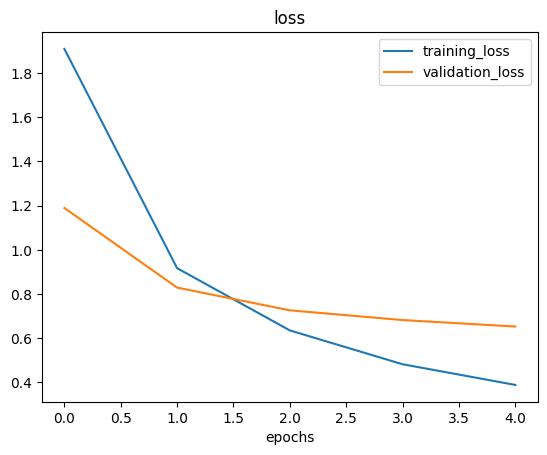

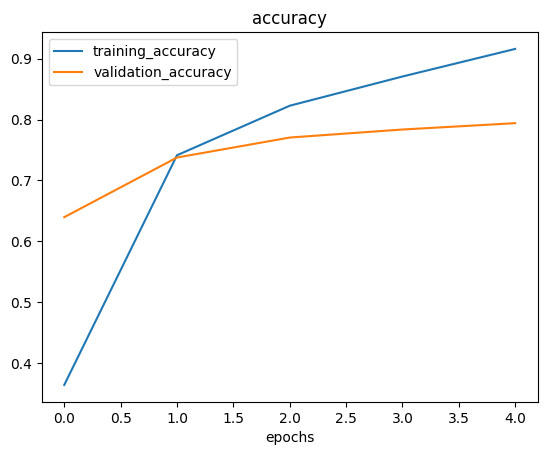

In [16]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0  Feature Extraction model

In [17]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet : https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(model_url=efficientnet_url,
                                   num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving tensorboard log files to : tensorflow_hub/efficientnetB0/20231011%H58
Epoch 1/5
24/24 [==============================] - 22s 506ms/step - loss: 1.8335 - accuracy: 0.4467 - val_loss: 1.2782 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 10s 420ms/step - loss: 1.0590 - accuracy: 0.7800 - val_loss: 0.8509 - val_accuracy: 0.8236
Epoch 3/5
24/24 [==============================] - 9s 400ms/step - loss: 0.7540 - accuracy: 0.8413 - val_loss: 0.6867 - val_accuracy: 0.8468
Epoch 4/5
24/24 [==============================] - 10s 424ms/step - loss: 0.6104 - accuracy: 0.8653 - val_loss: 0.5993 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 10s 432ms/step - loss: 0.5135 - accuracy: 0.8853 - val_loss: 0.5472 - val_accuracy: 0.8640


Seems like our EfficientNetB0 is better than our ResnetV2 model. It got 85% accuracy with only 10% of train data

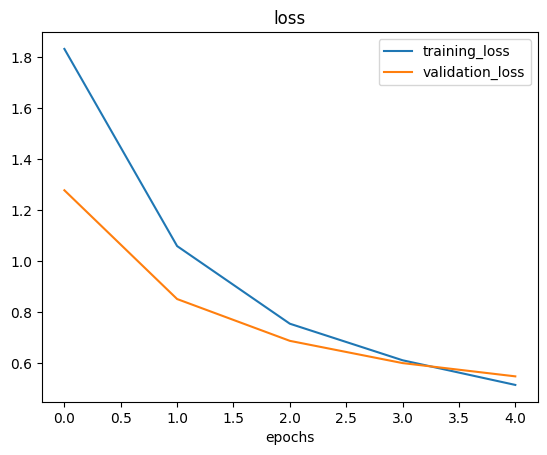

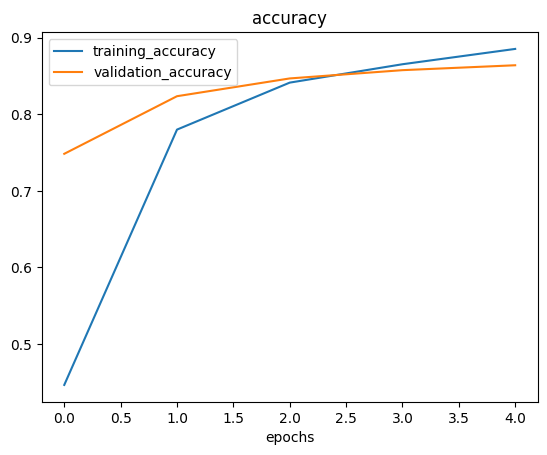

In [18]:
plot_loss_curves(efficientnet_history)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Using the feature extraction model to classify image in Pen and Pencil dataset (Optional).

In this section, I created my own dataset, process it, and tried our model to make predictions on.

The dataset structure is like this:
```
pen_pencil_images_04_challenge/
├── train/
│   ├── image1.jpg
│   ├── image2.jpg
│   ├── image3.jpg
│   └── image4.jpg
└── test/
    ├── image1.jpg
    ├── image2.jpg
    ├── image3.jpg
    └── image4.jpg
```
In case, you'd like to try that also.



In [ ]:
# Unzip our data
from zipfile import ZipFile

zip_reff = ZipFile("pen_pencil_images_04_challenge.zip")
zip_reff.extractall()
zip_reff.close()

Get the data by uploading from local computer

In [ ]:
# Preprocessing our data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up random seed
tf.random.set_seed(42)

# Set the hyperparameter
IMG_SHAPE = (224,224)

# Instantiate ImageDataGen object
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Set up the directory
train_dir = "pen_pencil_images_04_challenge/train"
test_dir = "pen_pencil_images_04_challenge/test"

# Import our data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMG_SHAPE,
                                               class_mode="binary"
                                               )

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMG_SHAPE,
                                             class_mode="binary",
                                             )

In [ ]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet : https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
resnet_model_2 = create_model(model_url=resnet_url,
                                    activation="sigmoid",
                                    num_classes=train_data.num_classes)

# Compile EfficientNet model
resnet_model_2.compile(loss="binary_crossentropy",
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=["accuracy"])

In [ ]:
# What if we train it without the test data
resnet_history_2= resnet_model_2.fit(train_data,
                         epochs=10,
                         steps_per_epoch=len(train_data),
                         validation_data=test_data,
                         validation_steps=len(test_data)
                         )

#### Predicting on custom data
To predict on custom data we need to:
1. Preprocess the data to be the same format as the model was trained on
2. Using our trained model to make prediction on

In [ ]:
# Let's get the subdirectories (these are our class names)
import pathlib

data_dir = pathlib.Path(train_dir) # acces the train dir
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # get the train dir subdirectories name

In [ ]:
# 1. Preprocess the data to be the same format as the model was trained on

filename = "/content/pen_pencil_images_04_challenge/test/pencil/ZJT4KKX1I09O.jpg" # pencil image to make prediction on
img_shape = 224


In [ ]:
# 2. Making prediction
resnet_model_pred = resnet_model_2.predict(tf.expand_dims(img, axis=0)) # expand dims for the batch size
resnet_model_pred

In [ ]:
# Turn the predicition into label
resnet_model_label = class_names[int(tf.round(resnet_model_pred))]
resnet_model_label